# Import Library

In [1]:
## find Astart 고친것 (모든 함수에서)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import queue
import random
from enum import Enum
from heapq import *
import copy

# Seed 고정

In [3]:
np.random.seed(10)
random.seed(10)

# Create Job

In [4]:
job_number  = 100

In [5]:
job_time_interval = np.random.poisson(10,job_number-1)
job_create_time = [sum(job_time_interval[:i]) for i in range(len(job_time_interval)+1)]
print(job_time_interval)
print(job_create_time)

[13 11 10  7  6 13 12 15 10  9  9 11 11 13 15  5 10  7  8  8  8  9 13  9
 13 10  4  8  8  8 14 14 11 11  8  8 10 10  8  8  4 11  8  8 12  3  5 14
  7 10  6 11  7  7 15 11 11 11  6 12  9 10  5 11  7  8 12  9 11 11 12 10
 10  6 10  5  5  4 11 11  8  9  9 10 19 14  7 10 13  8  9 14 11  9 10  8
 13  7 11]
[0, 13, 24, 34, 41, 47, 60, 72, 87, 97, 106, 115, 126, 137, 150, 165, 170, 180, 187, 195, 203, 211, 220, 233, 242, 255, 265, 269, 277, 285, 293, 307, 321, 332, 343, 351, 359, 369, 379, 387, 395, 399, 410, 418, 426, 438, 441, 446, 460, 467, 477, 483, 494, 501, 508, 523, 534, 545, 556, 562, 574, 583, 593, 598, 609, 616, 624, 636, 645, 656, 667, 679, 689, 699, 705, 715, 720, 725, 729, 740, 751, 759, 768, 777, 787, 806, 820, 827, 837, 850, 858, 867, 881, 892, 901, 911, 919, 932, 939, 950]


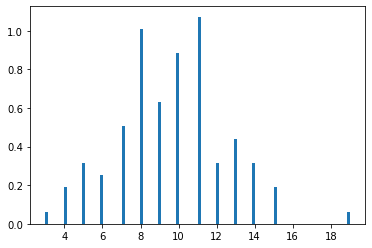

In [6]:
count, bins, ignored = plt.hist(job_time_interval, 100, density = True)
plt.show()

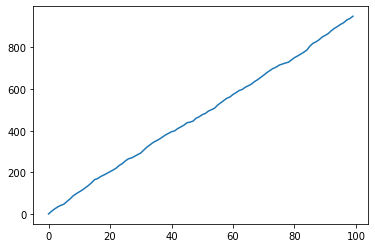

In [7]:
plt.plot(job_create_time)
plt.show()

# Job Queue

In [8]:
class JobQueue(object):
    
    def __init__(self):
        self.job_q = queue.Queue()
        self.job_number = 0
        
    def insertJob(self, inout,  station_dest):
        job = {"inout": inout, "station_dest": station_dest}
        self.job_q.put(job)
        self.job_number+=1

    def getJob(self):
        if self.job_q.empty():
            return 
        self.job_number-=1
        return self.job_q.get()

In [9]:
def job_create(rack_location,total_job_location_list,time,total_job_information):
    job_location = [random.choice(rack_location)]
    if total_job_location_list.count(job_location)%2==0:
        total_job_information['{}'.format(time)] = ['in',job_location]
    else:
        total_job_information['{}'.format(time)] = ['out',job_location]
    total_job_location_list.append(job_location)
    return total_job_information

# AGV

In [10]:
class AGV(object):
    max_battery = 200
    CHARGING_STATION = [(2,9),(6,9)]    
    
    def __init__(self,agv_id,current_location,job_for_bid,current_tick=0,cost=0,bid_list = []):
        self.agv_id = agv_id
        self.battery = self.max_battery
        self.current_location = current_location
        self.job = None
        self.destination = None
        self.available = True
        self.current_tick = current_tick
        self.to_chaging_station = False
        self.charging = False
        self.job_for_bid = job_for_bid
        self.bid_list = bid_list
        self.cost = cost 
        self.walking_path = []
        
        
#     def __str__(self):
#         return 'agv_id:{}  job:{}  available:{}'.format(self.agv_id, self.job, self.available)
    
#     def __str__(self):
#         return 'agv_id:{}'.format(self.agv_id)
    
    def move_one_tick(self):
        if len(self.path) !=0:
            self.walking_path += self.path[1:]
            self.next_location = self.path[0]
            self.current_location = self.next_location
            del self.path[0]
            if len(self.path) ==0:
                self.available = True
            self.battery -=1
            self.current_tick +=1
        else:
            self.available = True
            
    def move_one_tick_for_charge(self,charging_agvs_list,moving_for_charge_agvs):
        self.path_for_charge = self.castar_path_to_charger
        if len(self.path_for_charge) !=0:
            self.to_chaging_station = True
            self.next_location = self.path_for_charge[0]
            self.current_location = self.next_location
            del self.path_for_charge[0]
            self.battery -=1
            self.current_tick +=1
            if len(self.path_for_charge) ==0:
                charging_agvs_list.append(self)
                moving_for_charge_agvs.remove(self)
                self.to_chaging_station = False
                self.charging = True
#                 self.charging_agv()
#         else:
#             self.charging = True
    
    def get_job(self,job,castar_path):
        self.job = job
        self.path = castar_path
        self.available = False
        
    def go_to_charge(self,castar_path_to_charger):
        self.path_for_charge = castar_path_to_charger
        self.to_chaging_station = True
    
    
#     def agv_to_charging_station(self,battery_threshold):
#         if self.available == True and self.battery <= battery_threshold:
#             self.to_chaging_station = True

    def calculate_bid(self,job,warehouse,INPUT_STATION_tuple,OUTPUT_STATION_tuple,reservation_table,global_time):
#         print(job['station_dest'][1][0])
#         print("INPUT_STATION[0]",INPUT_STATION[0])
#         print("Rack_enterence[job['station_dest']]",Rack_enterence[job['station_dest']])
        if job['inout']=='in':
            cost = len(findPathAstar(graph,self,self.current_location,INPUT_STATION_tuple,reservation_table,global_time)+findPathAstar(graph,self,INPUT_STATION_tuple,Rack_enterence[job['station_dest']],reservation_table,global_time))
        else:
            cost = len(findPathAstar(graph,self,self.current_location,Rack_enterence[job['station_dest']],reservation_table,global_time)+findPathAstar(graph,self,Rack_enterence[job['station_dest']],OUTPUT_STATION_tuple,reservation_table,global_time))
        self.cost= cost 
        return self.cost,self
    
#     def calculate_cost_for_charing_bid(self,warehouse,CHARGING_STATION):
#         bid_for_charge = []
#         for charging_station in CHARGING_STATION:
#             bid_for_charge.append(charging_station,astar(warehouse,self.current_location,charging_station))
#         bid_for_charge_sort = sorted(bid_for_charge, key =lambda x:x[1])
#         selected_chargeing
#         return cost        
    
    
    def select_charging_station(self,warehouse,CHARGING_STATION,reservation_table,global_time):
        bid_for_charge = []
#         print('%',CHARGING_STATION)
        for charging_station in CHARGING_STATION:
#             if charging_station, booked
#             print("^",charging_station)
            bid_for_charge.append((charging_station,len(findPathAstar(graph,self,self.current_location,charging_station,reservation_table,global_time))))
        bid_for_charge_sort = sorted(bid_for_charge, key =lambda x:x[1])
#         print("$$bid_for_charge_sort",bid_for_charge_sort)
        selected_charging_station = bid_for_charge_sort[0][0]
        print("selected_charging_station : {}".format(selected_charging_station.coordinates))
        castar_path_to_charger = findPathAstar(graph,self,self.current_location,charging_station,reservation_table,global_time)
        print("need charging agv_id : {} castar_path_to_charger : {}".format(self.agv_id,[i.coordinates for i in castar_path_to_charger]))
        self.castar_path_to_charger = castar_path_to_charger
#         print('3',castar_path_to_charger)
        return selected_charging_station, castar_path_to_charger   
    
    
    def charge_agv(self,charging_agvs):
        if self.charging == True:
            self.battery +=10
            if self.battery >= self.max_battery:
                self.battery = self.max_battery
                self.charging = False 
                self.available=True
                charging_agvs.remove(self)
                
#                 
                

#     def win_bid(self)
        
    
    def drop_job(self):
        self.job = None
        self.available = True
        
    def clear_bid_list(self,agv_list):
        for agv in agv_list:
            agv.bid_list = []
            
            
    def copy(self):
        new_agent = Agent(self.pos, self.id)
        new_agent.path = self.path.copy()

        if self.pickup:
            # new_agent.pickup = Pickup(self.pickup.target_list[0], self.pickup.target_list[1])
            # new_agent.pickup.state = self.pickup.state
            new_agent.pickup = copy.deepcopy(self.pickup)

        new_agent.walking_path = self.walking_path.copy()
        new_agent.target_path = self.target_path.copy()
        new_agent.is_copy = self.is_copy
        new_agent.is_carrying_shelf = self.is_carrying_shelf
        new_agent.was_at_target = self.was_at_target

        return new_agent

In [11]:
def getAvailAGV(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.available == True and agv.battery > battery_threshold and agv.charging == False]

In [12]:
def getnNeedChargeAgv(AGV_LIST,battery_threshold):
    return [agv for agv in AGV_LIST if agv.charging == True and agv.battery <= battery_threshold and agv.charging == False and agv.to_chaging_station == False]

In [13]:
def getChargingAGV(AGV_LIST):
    return [agv for agv in AGV_LIST if agv.charging == True]

# Node

In [14]:
class NodeType(Enum):
    DEFAULT = 0
    OBSTACLE = 1
    INPUT = 2
    OUPUT = 3
    CHARGING_STATION = 4


class BasicNode(object):
    def __init__(self, new_id, new_type):
        self.id = new_id
        self.type = new_type

class AStarNode(BasicNode):
    def __init__(self, new_id, new_type, new_coordinaters):
        BasicNode.__init__(self, new_id, new_type)
        self.coordinates = new_coordinaters
        self.g = None
        self.h = None
        self.f = None
        self.came_from = None
        self.depth = 0
        self.booked = False

    def __lt__(self, other):
        if self.f == None or other.f == None:
            raise Exception("Some f value not initialized!")
        else:
            return self.f < other.f

    def __eq__(self, other):
        return (self.id == other.id and self.depth == other.depth)

    def __hash__(self):
        return self.id

    def compare(self, other):
        ok = True
        if self.id != other.id:
            print("1")
            return False
        if self.type != other.type:
            print("2")
            return False
        if self.coordinates != other.coordinates:
            print("3")
            return False
        if self.g != other.g:
            print("4")
            #return False
            ok = False
        if self.h != other.h:
            print("5")
            #return False
            ok = False
        if self.f != other.f:
            print("6")
            #return False
            ok = False
        if self.came_from and other.came_from:
            if self.came_from.id != other.came_from.id:
                print("7")
                ok = False
        elif self.came_from and not other.came_from:
            print("8")
            ok = False
        elif other.came_from and not self.came_from:
            print("9")
            ok = False
        if self.depth != other.depth:
            print("10")
            ok = False
        if self.booked != other.booked:
            print("11")
            ok = False

        if not ok:
            return False
        return True


# Charing Station

In [15]:
class ChargingStation(object):
    
    def __init__(self,charging_station_id,charging_station_location,agv_first_location_list):
        self.charging_station_location = charging_station_location
        if self.charging_station_location in agv_first_location_list:
            self.free = False
        else:
            self.free = True
        self.reserved = False
        
    def charging_station_reservation(self):
        self.reserved = True
        
    def charging_station_free(self):
        self.free = True
        self.reserved = False

In [16]:
def getAvail_ChargingStation(AGV_LIST):
    return [charging_station for charging_station in CHARING_STATION if charging_station.free == True]

# Function 

In [17]:
def reset_graph(graph):
    for i in range(0, graph.shape[0]):
        for j in range(0, graph.shape[1]):
            graph[j][i].g = None
            graph[j][i].h = None
            graph[j][i].f = None
            graph[j][i].came_from = None
            graph[j][i].depth = 0

In [18]:
def extract_path(current, graph=None):
    path = [current]
    next_node = current.came_from
    while next_node:
        path.insert(0, next_node)
        next_node = next_node.came_from

    for node in path:
        node.came_from = None
    # if graph != None:
    #     reset_graph(graph)
    return path

In [19]:
def manhattan_distance(start_node,goal_node):
    dx = abs(start_node.coordinates[0]-goal_node.coordinates[0])
    dy = abs(start_node.coordinates[1]-goal_node.coordinates[1])
    return dx + dy

In [20]:
## i와 j 바꾼거
def reset_f_val_graph(graph):
    for i in range(0, graph.shape[0]):
        for j in range(0, graph.shape[1]):
            graph[j][i].g = None
            graph[j][i].h = None
            graph[j][i].f = None
            graph[j][i].came_from = None

In [21]:
def warehouse_show(warehouse):
    return warehouse[::-1]

In [22]:
def get4Ways(point):
    return [(point[0],point[1]+1), (point[0]+1,point[1]),
            (point[0],point[1]-1), (point[0]-1,point[1])]

In [23]:
# def send_bid(avail_agv_list):
#     for agv_ in avail_agv_list:
#         agv_.bid_list.append((agv_,agv_.agv_id,agv_.cost))
            

In [24]:
def send_bid(avail_agv_list):
    bid_list = []
    for agv_ in avail_agv_list:
        bid_list.append(((agv_,agv_.agv_id,agv_.cost)))
    for agvs in avail_agv_list:
        agvs.bid_list = bid_list

In [25]:
## Rack_information 함수로 만들것

# Graph

In [26]:
def create_Astar_graph(warehouse):
    graph = np.ndarray((warehouse.shape), dtype=BasicNode)
    index = 0
    item_counter = 0
    input_station = []
    output_station = []
    charging_station = []
    for (i,j), value in np.ndenumerate(warehouse):
            graph[j][i] = AStarNode(index, NodeType(value), (j,i))
            if value == 2:
                graph[j][i].booked = False
                input_station.append(graph[j][i])
            if value == 3:
                output_station.append(graph[j][i])
                
            if value ==4:
                charging_station.append(graph[j][i])
            index += 1
    return graph, input_station, output_station ,charging_station

# Astar

In [27]:
def AStar(graph, start_tuple,goal_tuple, p=False):
    #reset_graph(graph)
    start = graph[start_tuple[0]][start_tuple[1]]
    start.depth = 0
    start.came_from = None
    target = graph[goal_tuple[0]][goal_tuple[1]]

    if p:
        print("new astar from %d to %d" % (start.id, target.id))

    start.g = 0
    start.h = manhattan_distance(start, target)
    start.f = start.h

    neighbours = [(0,1),(1,0),(-1,0),(0,-1)]

    open_list = []
    closed_list = set()

    heappush(open_list, start) # add start to open list

    while open_list:
        current = heappop(open_list)
        closed_list.add(current)

        if current.coordinates == target.coordinates:
            # target is found, extract the path
            return extract_path(current, graph)
####1차시도 for(i,j) -> for (j,i)로 변경 -> 실패 
###2차시도 x , y  = y, x
###3차시도 graph 에 있는x , y  = y, x
        for (i,j) in neighbours:
            x, y = (current.coordinates[0] + i, current.coordinates[1] + j)
            if x < 0 or x >= graph.shape[0] or y < 0 or y >= graph.shape[1]:
                # neighbour coordinates are out of the graph
                continue
            neighbour = graph[x][y]
            neighbour.depth = 0
            if neighbour.type == NodeType.OBSTACLE:
                continue
            if neighbour in closed_list:
                continue

            if neighbour not in open_list or current.g + 1 < neighbour.g:
                neighbour.g = current.g + 1
                neighbour.h = manhattan_distance(neighbour, target)
                neighbour.f = neighbour.g + neighbour.h
                neighbour.came_from = current
                if neighbour not in open_list:
                    heappush(open_list, neighbour)

In [28]:
#내가 생각하는 맞는것 + global_time
def collisionWillOccur(reservation_table, current, neighbour,global_time):
    if (current.depth+global_time + 1,neighbour.id) in reservation_table:
        # Moving to node collision
        return True
    if (current.depth + global_time+1,current.id) in reservation_table and (current.depth+global_time,neighbour.id) in reservation_table:
        # Swap collision
        return True
    return False

In [29]:
# #내가 생각하는 맞는것 
# def collisionWillOccur(reservation_table, current, neighbour):
#     if (current.depth + 1,neighbour.id) in reservation_table:
#         # Moving to node collision
#         return True
#     if (current.depth + 1,current.id) in reservation_table and (current.depth,neighbour.id) in reservation_table:
#         # Swap collision
#         return True
#     return False

In [30]:
def book_reservation_table(path_so_far,global_time,reservation_table):
    for time, value in enumerate(path_so_far):
        reservation_table[(value.depth+global_time, value.id)] = True
    return reservation_table

In [31]:
### start, goal 고친 후 
### gloabl_time을 추가한 이후 
## findPathAstar에 reservation까지 같이 들어 있음 
## findPathAstar에서 예약부분만 따로 떼어냄 

def findPathAstar(graph, agv,start_tuple,goal_tuple,reservation_table,global_time):
    global_time = global_time
    
    if type(start_tuple)==tuple:
        start = graph[start_tuple[0]][start_tuple[1]]
    else:
        start = graph[start_tuple.coordinates[0]][start_tuple.coordinates[1]] 
        
    if type(goal_tuple)==tuple:
        target = graph[goal_tuple[0]][goal_tuple[1]]
    else:
        target = graph[goal_tuple.coordinates[0]][goal_tuple.coordinates[1]]
    
    start.g = 0
    start.h = manhattan_distance(start,target)
    start.f = start.h
    
    neighbours = [(0,1),(1,0),(-1,0),(0,-1),(0,0)]
    open_list = []
    closed_list = set()   
    
    # add start to open list
    heappush(open_list, start)
    reached_target_last_step = False

    while open_list:
        current = heappop(open_list)
        current.depth = current.depth 
#         current.depth = current.depth + global_time
#         print("current : {} , current.depth : {}".format(current.coordinates,current.depth))
        ## 내가 추가한 부분 
        closed_list.add(current)
        if current.coordinates == target.coordinates:
            if not reached_target_last_step:
                reached_target_last_step = True
            else:
                path_so_far = extract_path(current) 
                                        
                return path_so_far
#                 return path_so_far + next_path[1:]
                
        else:
            reached_target_last_step = False
#         print("a")   
            
        for (i,j) in neighbours:
            x, y = (current.coordinates[0] + i, current.coordinates[1] + j)
            if x < 0 or x >= graph.shape[0] or y < 0 or y >= graph.shape[1]:
                # neighbour coordinates are out of the graph
                continue
#             print("c") 
            neighbour = graph[x][y]
            neighbour = copy.deepcopy(neighbour)
            ## 이부분에 tick 추가 (global)
#             neighbour.depth = current.depth +global_time+ 1
            neighbour.depth = current.depth + 1

            if neighbour.type == NodeType.OBSTACLE:
                # neighbour is not traversable, an obstacle
                #print("neigbout %d depth %d has OBSTACLE" % (neighbour.id, neighbour.depth))
                continue

            if neighbour in closed_list:
                # neighbour case has already been considered
                #print("neigbout %d depth %d has CLOSED" % (neighbour.id, neighbour.depth))
                continue

            if collisionWillOccur(reservation_table, current, neighbour, global_time):
                # can't move to neighbour since another agent is there
                #print("neigbout %d depth %d has colliiiishhh" % (neighbour.id, neighbour.depth))
                continue

            if neighbour in open_list:
                # make neighbour refer to correct node object
                for x in open_list:
                    if x == neighbour:
                        neighbour = x
                        break

            if neighbour not in open_list or current.g + 1 < neighbour.g:
                if neighbour.coordinates == target.coordinates:
                    # waiting at target is preferred
                    neighbour.g = current.g + 0
                else:
                    neighbour.g = current.g + 1
                neighbour.h = manhattan_distance(neighbour, target)
                neighbour.f = neighbour.g + neighbour.h

                # set parent
                neighbour.came_from = current

                if neighbour not in open_list:
                    # add newly discovered node to open list.
                    heappush(open_list, neighbour)
#     print("a")

    print("IMPOSSIBLE PROBLEM")
        

# CAstar Cost 계산 함수 

In [32]:
## global_time 추가, OUPUT_STATION의 tuple 형태, INPUT_STATION의 tuple 형태
def CAStar(graph,AGV_LIST,INPUT_STATION,OUTPUT_STATION,reservation_table,global_time):
    agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
    total_cost = 0
    while len(agv_avail)!=0 and jobQ.job_number!=0:
        job = jobQ.getJob()
        print(job)
#         print(job['station_dest'])
        agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
        for agv in agv_avail:
            agv.calculate_bid(job,warehouse,INPUT_STATION[0].coordinates,OUTPUT_STATION[0].coordinates)
            agv.bid_list.append(agv.calculate_bid(job,warehouse,INPUT_STATION[0].coordinates,OUTPUT_STATION[0].coordinates))
        for agv_ in agv_avail:
#             print(agv_bid_list)
            agv_bid_sort = sorted(agv_.bid_list,key = lambda x:x[0], reverse = False)
#             print(agv_bid_sort)
        bid_compare_battery=[]
        for i in range(len(agv_bid_sort)):
            if agv_bid_sort[i][1]==agv_bid_sort[0][1]:
                bid_compare_battery.append((agv_bid_sort[i]))
        bid_compare_battery_sort = sorted(bid_compare_battery, key= lambda x:x[1].battery, reverse =True)

        reset_graph(graph)
         
        if job['inout']=='in':
            castar_path = findPathAstar(graph,bid_compare_battery_sort[0][1],bid_compare_battery_sort[0][1].current_location,INPUT_STATION[0].coordinates,reservation_table,global_time)+findPathAstar(graph,bid_compare_battery_sort[0][1],INPUT_STATION[0].coordinates,Rack_enterence[job['station_dest']],reservation_table,global_time)
        else:
            castar_path = findPathAstar(graph,bid_compare_battery_sort[0][1],bid_compare_battery_sort[0][1].current_location,Rack_enterence[job['station_dest']],reservation_table,global_time)+findPathAstar(graph,bid_compare_battery_sort[0][1],Rack_enterence[job['station_dest']],OUTPUT_STATION[0].coordinates,reservation_table,global_time)
        if castar_path == None:
            return -1
        for time,value in enumerate(castar_path):
#             reservation_table[hash(value.depth, value.id)] = True 
            reservation_table[(value.depth+global_time, value.id)] = True  
        target_agv = bid_compare_battery_sort[0][1]
        select_agv_list.append(target_agv)
        target_agv.get_job(job,castar_path)
        print(" target_agv : {}, target_agv.battery: {}, destination : {}, castar_path : {}, available:{}".format(target_agv,target_agv.battery,job['station_dest'],[i.coordinates for i in castar_path],target_agv.available))
#         ### path 찍어보기 
#         for move in castar_path:
#             print(move.coordinates)
#         print(reservation_table)
        for agv in AGV_LIST:
                agv.clear_bid_list(AGV_LIST)
        agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
        for agv in AGV_LIST:
            total_cost += len(agv.walking_path)
            return total_cost

# Main 함수

In [33]:
def main():
    global number_of_tests
    cost_CA= []
    input_size_items = []
    input_size_orders = []
    select_agv_list = []
    charging_agvs_list = []
    moving_for_charge_agvs_list = []
#     number_of_agents = 20
    failed_count = 0
    impossible_problems_CA = 0
    for test_number in range(0,number_of_tests):
        print("starting test {}".format(test_number))
        order_input = len(total_job_information)
        graph, INPUT_STATION, OUTPUT_STATION, CHARGING_STATION = create_Astar_graph(warehouse)
        for running_time in range(run_time+1):
            now_charging_agv = getChargingAGV(AGV_LIST)
            
            
            ### reservation_table 삭제 
            delete = []
            if running_time-1>=0:
                for keys in reservation_table.keys():
                    if keys[0]==running_time-1:
                        delete.append(keys)
                for _ in delete:
                    del reservation_table[_]
                
            
            if len(now_charging_agv)!=0:
                print('time : {}, charging_agv : {}'.format(running_time,[i.agv_id for i in now_charging_agv]))
            if len(now_charging_agv)!=0:
                for charging_agv in now_charging_agv:
                    charging_agv.charge_agv(charging_agvs_list)
            if len(moving_for_charge_agvs_list)!=0:
    #             print('-',moving_for_charge_agvs_list)
                for moving_agvs in moving_for_charge_agvs_list :
                    moving_agvs.move_one_tick_for_charge(charging_agvs_list,moving_for_charge_agvs_list)
                    print("running time : {}, moving agv for charging : {}, current location : {}, current battery : {}".format(running_time, moving_agvs.agv_id,moving_agvs.current_location.coordinates,moving_agvs.battery))
                    if moving_agvs.charging == True:
                        print('moving_for_charge_agvs_list :',moving_for_charge_agvs_list,'moving_agvs : ',moving_agvs.agv_id,'moving_agvs battery :',moving_agvs.battery)
    #                     moving_for_charge_agvs_list.remove(moving_agvs)
                        charging_agvs_list.append(moving_agvs)
        #       #사용가능한 agv와 job이 있을때 
            if running_time in job_create_time:
                print("@@@@@@@@@@@@@@@@@",running_time)
                jobQ.insertJob(total_job_information.get('{}'.format(running_time))[0],total_job_information.get('{}'.format(running_time))[1][0])
            agv_avail = getAvailAGV(AGV_LIST,battery_threshold)
            while len(agv_avail)!=0 and jobQ.job_number!=0:
#                 AGV는 제대로 나옴 
#                 print("@#@agv_avail",agv_avail)
                job = jobQ.getJob()
#                 print(job)
                print("runningtime : {}, available_agv : {}".format(running_time,[agv.agv_id for agv in agv_avail]))
        #         print(job['station_dest'])
                agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
            #01#
                for agv in agv_avail:
                    agv.calculate_bid(job,graph,INPUT_STATION[0].coordinates,OUTPUT_STATION[0].coordinates,reservation_table,running_time)
                    
                send_bid(agv_avail)            
                
                for agv_ in agv_avail:
#                     print("agv_bid_listagv_bid_list",agv_.bid_list)
                    agv_bid_sort = sorted(agv_.bid_list,key = lambda x:x[2], reverse = False)
#                     print("agv_bid_sort",agv_bid_sort)
                bid_compare_battery=[]
                for i in range(len(agv_bid_sort)):
                    if agv_bid_sort[i][1]==agv_bid_sort[0][1]:
                        bid_compare_battery.append((agv_bid_sort[i]))
                
                bid_compare_battery_sort = sorted(bid_compare_battery, key= lambda x:x[0].battery, reverse =True)
#                 print("bid_compare_battery_sort",bid_compare_battery_sort)
                reset_graph(graph)
#                 print("bid_compare_battery_sort[0][1]",bid_compare_battery_sort[0][1])
#                 print("bid_compare_battery_sort[0][1].current_location",bid_compare_battery_sort[0][1].current_location)
#                 print("INPUT_STATION[0].coordinates",INPUT_STATION[0].coordinates)
#                 print("Rack_enterence[job['station_dest']]",Rack_enterence[job['station_dest']])
                if job['inout']=='in':
                    path_agvloc_to_in = findPathAstar(graph,bid_compare_battery_sort[0][0],bid_compare_battery_sort[0][0].current_location,INPUT_STATION[0].coordinates,reservation_table,running_time) 
                    path_in_to_rack = findPathAstar(graph,bid_compare_battery_sort[0][0],INPUT_STATION[0].coordinates,Rack_enterence[job['station_dest']],reservation_table,running_time+len(path_agvloc_to_in))
                    castar_path = path_agvloc_to_in + path_in_to_rack
                    book_reservation_table(path_agvloc_to_in,running_time,reservation_table)
                    book_reservation_table(path_in_to_rack,running_time+len(path_agvloc_to_in),reservation_table)
                else:
                    path_agvloc_to_rack = findPathAstar(graph,bid_compare_battery_sort[0][0],bid_compare_battery_sort[0][0].current_location,Rack_enterence[job['station_dest']],reservation_table,running_time)
                    path_rack_to_out = findPathAstar(graph,bid_compare_battery_sort[0][0].current_location,Rack_enterence[job['station_dest']],OUTPUT_STATION[0].coordinates,reservation_table,running_time+len(path_agvloc_to_rack))
                    book_reservation_table(path_agvloc_to_rack,running_time,reservation_table)
                    book_reservation_table(path_rack_to_out,running_time+len(path_agvloc_to_rack),reservation_table)
                    print("path_agvloc_to_rack",len(path_agvloc_to_rack))
                    castar_path = path_agvloc_to_rack+path_rack_to_out
#                 print([i.coordinates for i in castar_path])
                if castar_path == None:
                    return -1
                                
                ##3##    
                

#                 for time,value in enumerate(castar_path):
#         #             reservation_table[hash(value.depth, value.id)] = True 
#                     reservation_table[(value.depth+running_time, value.id)] = True  
#                 print(reservation_table)
                
                target_agv = bid_compare_battery_sort[0][0]
                select_agv_list.append(target_agv)
                target_agv.get_job(job,castar_path)
                print("D running_time : {}, target_agv : {}, target_agv.battery: {}, destination : {}, castar_path : {}, available:{}".format(running_time,target_agv.agv_id,target_agv.battery,job['station_dest'],[i.coordinates for i in castar_path],target_agv.available))
                for agv_ in agv_avail:
                    agv_.bid_list = []
                agv_avail = getAvailAGV(AGV_LIST, battery_threshold)
#             one_algorithm_failed = False 
#             print("INPUT_STATION.coordinates",INPUT_STATION[0].coordinates,"OUTPUT_STATION.coordinates",OUTPUT_STATION[0].coordinates)
            #@#
            # cost 계산부분
#             current_COST = CAStar(graph,AGV_LIST,INPUT_STATION,OUTPUT_STATION,reservation_table,running_time)
#             if current_COST ==-1:
#                 impossible_problems_CA +=1
#                 one_algorithm_failed = True
#             cost_CA.append(current_COST)


##################################################추가#######################################################################    

    #         print('C running_time : {} , agv_avail : {}'.format(running_time,agv_avail))
            for moving_agv in select_agv_list:
                moving_agv.move_one_tick()
#                 print("RTRTRT",reservation_table)
                print("E time : {}, moving agv : {}, battery : {}, current location : {}".format(running_time,moving_agv.agv_id,moving_agv.battery,moving_agv.current_location.coordinates))
                if len(moving_agv.path)==0:
                    select_agv_list.remove(moving_agv)
                    moving_agv.available = True
                    if moving_agv.battery < battery_threshold:
                        moving_for_charge_agvs_list.append(moving_agv)
                        moving_agv.go_to_charge(moving_agv.select_charging_station(graph,CHARGING_STATION,reservation_table,running_time))
        
        number_of_tests = number_of_tests - failed_count   
        if number_of_tests <= 0:
            print("No simulations were successful")
            return
        print("cost_CA",cost_CA)
        avg_cost_CA = np.sum(cost_CA) / number_of_tests
        print("The average cost for CA: %.3f" % (avg_cost_CA))
        print("impossible problems encountered: CA: %d" % (impossible_problems_CA))
                


# 실험

### Simulation condition

In [34]:
warehouse = np.array(
[[0, 0, 0, 2, 0, 0, 3, 0, 0, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 4, 0, 4, 0, 0, 4, 0, 4, 0]]
,dtype = np.int32)

In [35]:
warehouse_show(warehouse)

array([[0, 4, 0, 4, 0, 0, 4, 0, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
       [0, 0, 0, 2, 0, 0, 3, 0, 0, 0]])

In [36]:
jobQ = JobQueue()
jobQ_for_simulation = JobQueue()
run_time = 2000
total_job_location_list = []
select_agv_list = []
charging_agvs_list = []
moving_for_charge_agvs_list = []
battery_threshold = 100
total_job_information = {}
number_of_tests = 1
reservation_table = {}
graph, INPUT_STATION, OUTPUT_STATION, CHARGING_STATION = create_Astar_graph(warehouse)
rack_location =  [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7),
                  (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), 
                  (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), 
                  (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), 
                  (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), 
                  (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7)]

In [37]:
Rack_enterence={}
for point in rack_location:
    four_ways = get4Ways(point)
    neighbour_obstacle_list = [way for way in four_ways if way in rack_location]  ## 좌표정보 ex) (1,3), (2,2)....
    neighbour_empty_list = [way for way in four_ways if way not in rack_location] 
    if len(neighbour_empty_list) == 1: ### 모서리 아님
        Rack_enterence[point] = neighbour_empty_list[0]
    elif len(neighbour_empty_list) == 2: ### 모서리임
        obstacle_way_list = [four_ways.index(obst) for obst in neighbour_obstacle_list]  ## 방향정보 ex) 0,1, 2...
        for idx, obst_point in enumerate(neighbour_obstacle_list):
            obst_way = obstacle_way_list[idx]
            obst_plus1_point = get4Ways(obst_point)[obst_way]
            if obst_plus1_point in rack_location:
                continue
            else:
                Rack_enterence[point] = four_ways[obst_way-2]
    else:
        print('ERROR finding obstacle/entrance for RACK {}'.format(point))

### Created Job 확인

In [38]:
for time in range(run_time+1):
    if time in job_create_time:
        job_create(rack_location,total_job_location_list,time,total_job_information)
print(total_job_information)
print(len(total_job_information))

{'0': ['in', [(8, 2)]], '13': ['in', [(1, 3)]], '24': ['in', [(5, 7)]], '34': ['in', [(7, 3)]], '41': ['out', [(8, 2)]], '47': ['in', [(1, 1)]], '60': ['in', [(2, 7)]], '72': ['in', [(7, 2)]], '87': ['in', [(7, 4)]], '97': ['in', [(4, 4)]], '106': ['in', [(8, 7)]], '115': ['in', [(2, 4)]], '126': ['out', [(1, 3)]], '137': ['in', [(7, 6)]], '150': ['out', [(7, 4)]], '165': ['in', [(4, 7)]], '170': ['in', [(1, 5)]], '180': ['in', [(4, 2)]], '187': ['in', [(5, 3)]], '195': ['in', [(1, 3)]], '203': ['in', [(5, 6)]], '211': ['in', [(2, 2)]], '220': ['in', [(8, 4)]], '233': ['in', [(5, 2)]], '242': ['in', [(5, 4)]], '255': ['out', [(5, 6)]], '265': ['in', [(4, 5)]], '269': ['in', [(4, 3)]], '277': ['out', [(7, 2)]], '285': ['in', [(2, 5)]], '293': ['in', [(4, 6)]], '307': ['out', [(5, 3)]], '321': ['out', [(2, 2)]], '332': ['in', [(7, 2)]], '343': ['out', [(4, 2)]], '351': ['in', [(7, 1)]], '359': ['in', [(8, 5)]], '369': ['out', [(5, 4)]], '379': ['out', [(1, 3)]], '387': ['in', [(8, 3)]], 

### Charging station 생성

In [39]:
print(CHARGING_STATION)

[<__main__.AStarNode object at 0x00000135E8380C40>, <__main__.AStarNode object at 0x00000135E83802B0>, <__main__.AStarNode object at 0x00000135E8380E20>, <__main__.AStarNode object at 0x00000135E8380E50>]


In [40]:
# CHARGING_STATION_ENTER = 

In [41]:
Rack_enterence={}
for point in rack_location:
    four_ways = get4Ways(point)
    neighbour_obstacle_list = [way for way in four_ways if way in rack_location]  ## 좌표정보 ex) (1,3), (2,2)....
    neighbour_empty_list = [way for way in four_ways if way not in rack_location] 
    if len(neighbour_empty_list) == 1: ### 모서리 아님
        Rack_enterence[point] = neighbour_empty_list[0]
    elif len(neighbour_empty_list) == 2: ### 모서리임
        obstacle_way_list = [four_ways.index(obst) for obst in neighbour_obstacle_list]  ## 방향정보 ex) 0,1, 2...
        for idx, obst_point in enumerate(neighbour_obstacle_list):
            obst_way = obstacle_way_list[idx]
            obst_plus1_point = get4Ways(obst_point)[obst_way]
            if obst_plus1_point in rack_location:
                continue
            else:
                Rack_enterence[point] = four_ways[obst_way-2]
    else:
        print('ERROR finding obstacle/entrance for RACK {}'.format(point))

### Create AGV

In [42]:
## agv 위치 Random 하게 선택 
agv1 = AGV("agv1",(0,9),[])
agv2 = AGV("agv2",(3,9),[])
agv3 = AGV("agv3",(6,9),[])
agv4 = AGV("agv4",(9,9),[])
AGV_LIST = [agv1,agv2,agv3,agv4]
AGV_LIST

In [43]:
# #실험1 같은 time 상황에서 제대로 동작한다. path1이 설정되면 path2는 알아서 피하는 경로 설정 -> CA* 
# path1 = findPathAstar(graph, agv1, (9,8),(4,0),reservation_table,0)
# book_reservation_table(path1,0,reservation_table)
# for i in path1:
#     print(i.coordinates)
# print(reservation_table)

In [44]:
# path2 = findPathAstar(graph, agv1, (8,9),(3,0),reservation_table,0)
# book_reservation_table(path2,0,reservation_table)
# for i in path2:
#     print(i.coordinates)
# print(reservation_table)

In [45]:
# #실험1 같은 time 상황에서 제대로 동작한다. path1이 설정되면 path2는 알아서 피하는 경로 설정 -> CA* 
# #global tick을 포함해서 CA*가 잘 작동함 
# ## 그러나 작업을 새로 받지 앟으면 reservation table에 현재 위치를 계속 예약하는 것이 되어있지 않다, 
# # 새로운 작업을 받지 않으면 치워버려야 한다. 어디로 치워야 하나? 뒤로 치우는 것이 어떨까?
# t = findPathAstar(graph, agv1, (9,8),(4,0),reservation_table,0)
# path1 = findPathAstar(graph, agv1, (9,8),(4,0),reservation_table,0)
# path2 = findPathAstar(graph, agv1, (4,0),(9,0),reservation_table,len(path1))
# path0 = findPathAstar(graph, agv1, (4,8),(4,0),reservation_table,0)
# cost =  path1+path0+path2
# print([i.coordinates for i in cost])
# book_reservation_table(path1,0,reservation_table)
# book_reservation_table(path2,len(path1),reservation_table)
# book_reservation_table(path0,len(path1)+len(path2),reservation_table)
# print(reservation_table)
# print("여기까지 path1")
# path3 = findPathAstar(graph, agv2, (7,9),(3,0),reservation_table,1)
# path4 = findPathAstar(graph, agv2, (3,0),(4,0),reservation_table,1)
# cost1 = path3 + path4
# print([i.coordinates for i in cost1])
# book_reservation_table(path3,1,reservation_table)
# book_reservation_table(path4,len(path3),reservation_table)
# print(reservation_table)
# # print("여기까지 path2")
# # path5 = findPathAstar(graph, agv3, (9,9),(3,3),reservation_table,3)
# # book_reservation_table(path3,3,reservation_table)
# # print(reservation_table)

In [46]:
if __name__ == "__main__":
    main()

starting test 0
@@@@@@@@@@@@@@@@@ 0
runningtime : 0, available_agv : ['agv1', 'agv2', 'agv3', 'agv4']
D running_time : 0, target_agv : agv2, target_agv.battery: 200, destination : (8, 2), castar_path : [(3, 9), (3, 8), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (3, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (9, 1), (9, 2), (9, 2)], available:False
E time : 0, moving agv : agv2, battery : 199, current location : (3, 9)
E time : 1, moving agv : agv2, battery : 198, current location : (3, 8)
E time : 2, moving agv : agv2, battery : 197, current location : (3, 7)
E time : 3, moving agv : agv2, battery : 196, current location : (3, 6)
E time : 4, moving agv : agv2, battery : 195, current location : (3, 5)
E time : 5, moving agv : agv2, battery : 194, current location : (3, 4)
E time : 6, moving agv : agv2, battery : 193, current location : (3, 3)
E time : 7, moving agv : agv2, battery : 192, current location : (3, 2)
E time : 8, moving agv : agv2, batte

E time : 175, moving agv : agv2, battery : 126, current location : (3, 0)
E time : 176, moving agv : agv1, battery : 115, current location : (3, 6)
E time : 176, moving agv : agv2, battery : 125, current location : (2, 0)
E time : 177, moving agv : agv1, battery : 114, current location : (3, 7)
E time : 177, moving agv : agv2, battery : 124, current location : (1, 0)
E time : 178, moving agv : agv1, battery : 113, current location : (3, 7)
E time : 179, moving agv : agv2, battery : 123, current location : (0, 0)
@@@@@@@@@@@@@@@@@ 180
runningtime : 180, available_agv : ['agv1', 'agv3', 'agv4']
D running_time : 180, target_agv : agv1, target_agv.battery: 113, destination : (4, 2), castar_path : [(3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (3, 0), (3, 0), (3, 1), (3, 2), (3, 2)], available:False
E time : 180, moving agv : agv2, battery : 122, current location : (0, 1)
E time : 180, moving agv : agv1, battery : 112, current location : (3, 7)
E time : 181, moving agv : a

path_agvloc_to_rack 14
D running_time : 286, target_agv : agv2, target_agv.battery: 159, destination : (7, 2), castar_path : [(3, 5), (3, 6), (3, 7), (3, 8), (4, 8), (5, 8), (6, 8), (6, 7), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (6, 2), (6, 2), (6, 1), (6, 0), (6, 0)], available:False
E time : 286, moving agv : agv4, battery : 184, current location : (3, 0)
E time : 286, moving agv : agv2, battery : 158, current location : (3, 5)
running time : 287, moving agv for charging : agv3, current location : (8, 9), current battery : 74
E time : 287, moving agv : agv4, battery : 183, current location : (3, 0)
E time : 287, moving agv : agv2, battery : 157, current location : (3, 6)
running time : 288, moving agv for charging : agv3, current location : (8, 9), current battery : 73
moving_for_charge_agvs_list : [] moving_agvs :  agv3 moving_agvs battery : 73
E time : 288, moving agv : agv4, battery : 182, current location : (3, 1)
E time : 288, moving agv : agv2, battery : 156, current location 

D running_time : 351, target_agv : agv2, target_agv.battery: 117, destination : (7, 1), castar_path : [(6, 0), (5, 0), (6, 0), (6, 1), (6, 1), (6, 0), (5, 0), (4, 0), (3, 0), (3, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 1)], available:False
E time : 351, moving agv : agv3, battery : 168, current location : (3, 1)
E time : 351, moving agv : agv2, battery : 116, current location : (6, 0)
E time : 352, moving agv : agv3, battery : 167, current location : (3, 0)
E time : 352, moving agv : agv2, battery : 115, current location : (5, 0)
E time : 353, moving agv : agv3, battery : 166, current location : (4, 0)
E time : 353, moving agv : agv2, battery : 114, current location : (6, 0)
E time : 354, moving agv : agv3, battery : 165, current location : (5, 0)
E time : 354, moving agv : agv2, battery : 113, current location : (6, 1)
E time : 355, moving agv : agv3, battery : 164, current location : (6, 0)
E time : 355, moving agv : agv2, battery : 112, current location : (6, 1)
E time : 356

path_agvloc_to_rack 10
D running_time : 426, target_agv : agv2, target_agv.battery: 200, destination : (4, 6), castar_path : [(8, 9), (7, 9), (7, 8), (6, 8), (5, 8), (4, 8), (3, 8), (3, 7), (3, 6), (3, 6), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (4, 0), (5, 0), (6, 0), (6, 0)], available:False
E time : 426, moving agv : agv4, battery : 97, current location : (3, 2)
E time : 426, moving agv : agv2, battery : 199, current location : (8, 9)
E time : 427, moving agv : agv4, battery : 96, current location : (3, 3)
E time : 427, moving agv : agv2, battery : 198, current location : (7, 9)
E time : 428, moving agv : agv4, battery : 95, current location : (3, 4)
E time : 428, moving agv : agv2, battery : 197, current location : (7, 8)
E time : 429, moving agv : agv4, battery : 94, current location : (3, 5)
E time : 429, moving agv : agv2, battery : 196, current location : (6, 8)
E time : 430, moving agv : agv4, battery : 93, current location : (3, 6)
E time : 430, moving agv : a

path_agvloc_to_rack 9
D running_time : 466, target_agv : agv4, target_agv.battery: 200, destination : (4, 7), castar_path : [(8, 9), (7, 9), (7, 8), (6, 8), (5, 8), (4, 8), (3, 8), (3, 7), (3, 7), (3, 7), (3, 6), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0), (4, 0), (5, 0), (6, 0), (6, 0)], available:False
E time : 466, moving agv : agv2, battery : 161, current location : (5, 0)
E time : 466, moving agv : agv4, battery : 199, current location : (8, 9)
time : 467, charging_agv : ['agv3']
@@@@@@@@@@@@@@@@@ 467
E time : 467, moving agv : agv2, battery : 160, current location : (4, 0)
E time : 467, moving agv : agv4, battery : 198, current location : (7, 9)
time : 468, charging_agv : ['agv3']
E time : 468, moving agv : agv2, battery : 159, current location : (3, 0)
E time : 468, moving agv : agv4, battery : 197, current location : (7, 8)
time : 469, charging_agv : ['agv3']
E time : 469, moving agv : agv2, battery : 158, current location : (3, 1)
E time : 469, moving agv : agv4, battery :

TypeError: can only concatenate list (not "NoneType") to list